## IGAE

The following code is used to create and update monthly figures of the Mexican economic activity indicator (IGAE)

In [467]:
import sys
import os
import pandas as pd
import numpy as np


# For creating cool charts :)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
from matplotlib import image
import matplotlib as mpl
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.dates as mdates

# We load pre-defined functions, fonts and stylesheet.
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\utils")
    sys.path.append(module_path+"\\assets")

from tukan_helper_functions import *

path = [x for x in sys.path if "utils" in x][0]

# Optional for TUKAN's mplstylesheet
plt.style.use(module_path + '\\utils\\tukan_style.mpl')

### Getting the data

In [468]:
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "group_by": [
        "adjustment_type",
        "economic_activity"
    ],
    "categories": {
        "adjustment_type": [
            "61060325ab095ed" #a7e5d5a7d084363/original, 61060325ab095ed/estacional
        ],
        "economic_activity": "all"
    },
    "request": [
        {
            "table": "mex_inegi_igae",
            "variables": [
                "fa581e55c3b52cb"
            ]
        }
    ],
    "from": "2000-01-01"
}

response = get_tukan_api_request(payload)

Success getting the data


In [469]:
df = response["data"]
df

,date,adjustment_type__ref,adjustment_type,economic_activity__ref,economic_activity,fa581e55c3b52cb
0,2000-01-01,61060325ab095ed,Ajuste estacional,169c33ccdd66d77,Comercio al por mayor,68.663376
1,2000-01-01,61060325ab095ed,Ajuste estacional,23cf92d98dd7c11,Comercio al por menor,76.947058
2,2000-01-01,61060325ab095ed,Ajuste estacional,36348912d8470dd,"Generación, transmisión, distribución y comerc...",53.813249
3,2000-01-01,61060325ab095ed,Ajuste estacional,3726993cc9fecab,Servicios de apoyo a los negocios y manejo de ...,78.339720
4,2000-01-01,61060325ab095ed,Ajuste estacional,44d246411040129,Servicios inmobiliarios y de alquiler de biene...,59.692813
...,...,...,...,...,...,...
6044,2021-11-01,61060325ab095ed,Ajuste estacional,e426cc87d0540ab,Información en medios masivos,131.234208
6045,2021-11-01,61060325ab095ed,Ajuste estacional,f5adaadda584ca7,"Actividades legislativas, gubernamentales, de ...",105.313546
6046,2021-11-01,61060325ab095ed,Ajuste estacional,faa2a8d0af8a72c,Industrias manufactureras,112.197385
6047,2021-11-01,61060325ab095ed,Ajuste estacional,fcb303b72a98f6c,Servicios educativos,103.838934


### Global Economic Activity

In [470]:
df_global = df[df["economic_activity__ref"] == "dfeefc621d16d0c"].copy()
df_global.reset_index(drop = True, inplace = True)
df_global.loc[:,"mom"] = df_global["fa581e55c3b52cb"]/df_global["fa581e55c3b52cb"].shift(1) - 1
df_global.loc[:,"yoy"] = df_global["fa581e55c3b52cb"]/df_global["fa581e55c3b52cb"].shift(12) - 1 

In [471]:
# Check if there has been a MoM contraction
df_global.loc[:,"contraction"] = [True if x < 0 else False for x in df_global["mom"]]
# df_global

In [472]:
# Count for consecutive contractions.

df_global_bool = df_global["contraction"] != df_global["contraction"].shift()
df_cum = df_global_bool.cumsum()

groups = df_global.where(df_global['contraction'] == True).groupby(df_cum)


groupCounts = groups.agg({'date':['count', 'min', 'max']})
groupCounts.columns = groupCounts.columns.droplevel()
groupCounts[groupCounts["count"] > 3]


,count,min,max
contraction,,,
4,8,2000-10-01,2001-05-01
52,7,2008-11-01,2009-05-01
110,4,2020-02-01,2020-05-01


In [473]:
df_global["mom"].tail(5)*100

258    0.163379
259   -1.180802
260   -0.297781
261   -0.168754
262    0.349502
Name: mom, dtype: float64

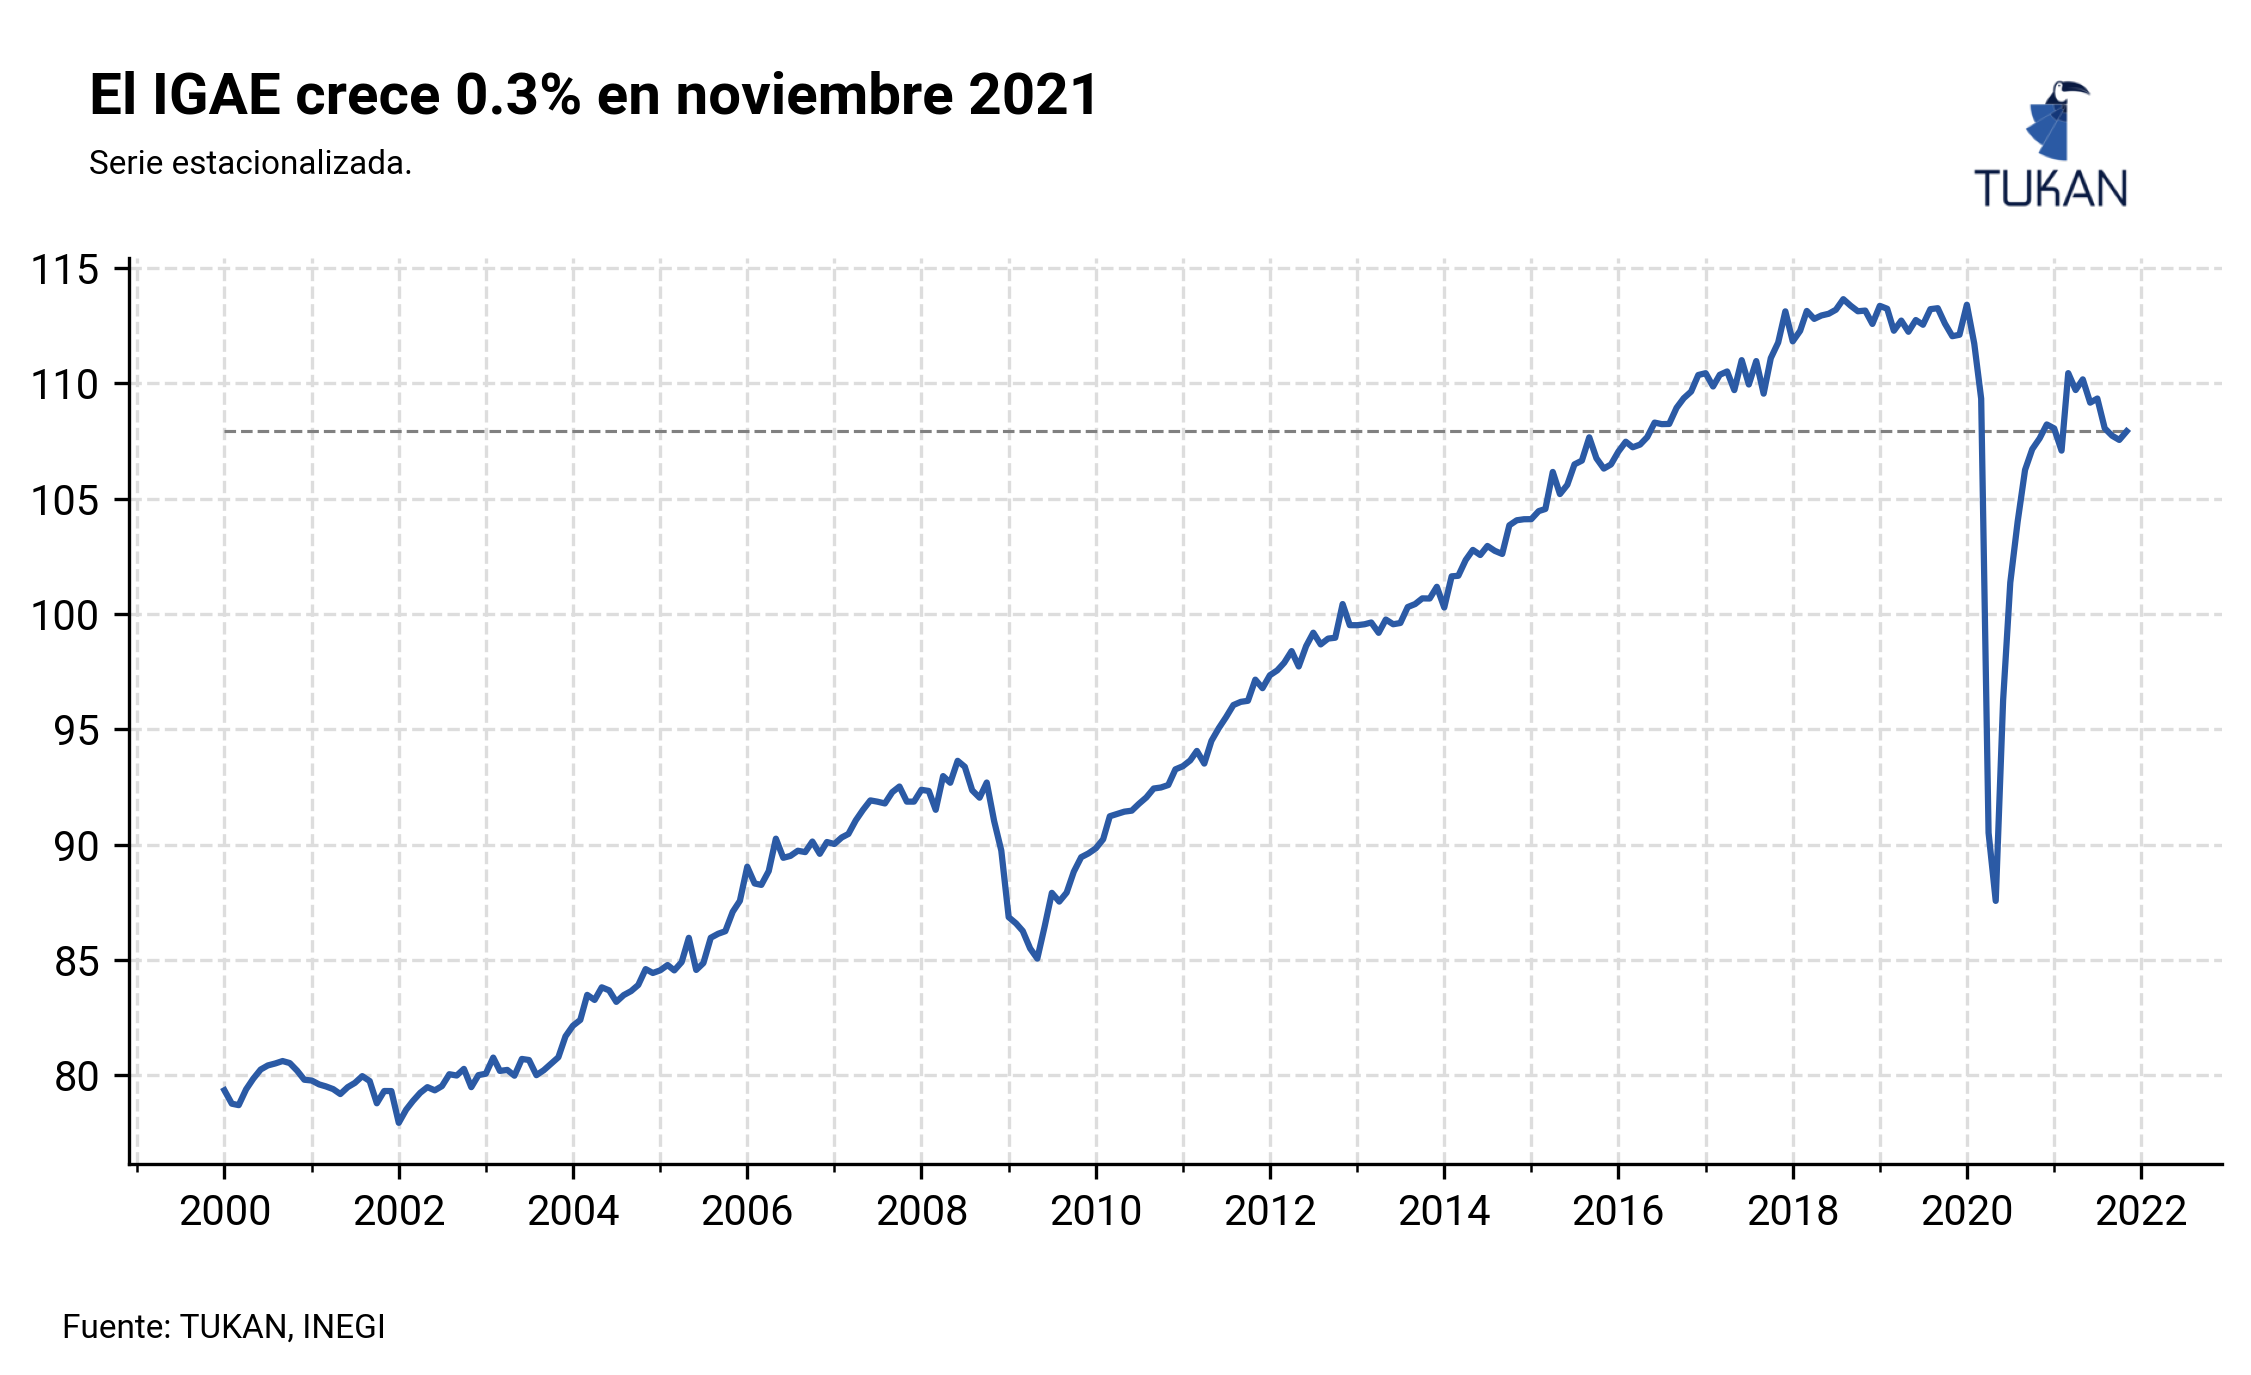

In [474]:
fig = plt.figure(dpi=300, figsize=(9,4))
ax = plt.subplot(111)

ax.hlines(y = df_global["fa581e55c3b52cb"].iloc[-1], xmin = df_global["date"].iloc[0], xmax = df_global["date"].iloc[-1], color = "gray", ls = "--", linewidths = 0.75)
ax.plot(df_global["date"], df_global["fa581e55c3b52cb"])

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
# Add minor gridlines and format ticks
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))

ax.grid(visible=True, which='minor', linestyle='--')


# ax.set_ylim(0)

fig.text(
    0.11,
    1,
    "El IGAE crece 0.3% en noviembre 2021",
    size=14,
    weight = "bold"
)

fig.text(
    0.11,
    0.95,
    "Serie estacionalizada.",
    size=8
)
# Add footer
fig.text(0.1, -0.02, "Fuente: TUKAN, INEGI", fontsize=8)


tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.72, .88, 0.16, 0.19], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")


plt.savefig(
    "plots/igae_ts_logo_white.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

### Selected Economic Activities

In [475]:
# df[["economic_activity"]].drop_duplicates()

In [476]:
sec_igae = df[df["economic_activity__ref"] == "761bc00426e1c48"].copy()
sec_igae.reset_index(drop = True, inplace = True)
sec_igae = df_global[['date','fa581e55c3b52cb']].copy()
sec_igae.rename(columns={'fa581e55c3b52cb':'igae'}, inplace=True)
# sec_igae

In [477]:
ter_igae = df[df["economic_activity__ref"] == "8fd5b02b9f891fb"].copy()
ter_igae.reset_index(drop = True, inplace = True)
ter_igae = df_global[['date','fa581e55c3b52cb']].copy()
ter_igae.rename(columns={'fa581e55c3b52cb':'igae'}, inplace=True)
# ter_igae

## IOAE

In [478]:
xls = pd.ExcelFile("Datos_IOAE.xlsx")
xls.sheet_names
# mensual_ioae = pd.read_excel(xls,xls.sheet_names[2])

['Grandes Actividades Económicas',
 'Variación anual IOAE',
 'Variación mensual IOAE',
 'Índice IOAE',
 'Variacion anual Act_Sec',
 'Variacion mensual Act_Sec',
 'Índice Act_Sec',
 'Variación anual Act_Ter',
 'Variacion mensual Act_Ter',
 'Índice Act_Ter']

### Aggregated Index

In [479]:
ioae = pd.read_excel(xls,xls.sheet_names[3])
ioae['Fecha'] = ioae['Fecha']+'/01'
ioae['Fecha'] = pd.to_datetime(ioae['Fecha'], format='%Y/%m/%d')
ioae['Índice IOAE'] = ioae['Índice IOAE'].fillna(ioae['Índice IGAE'])
ioae.drop(columns='Índice IGAE', inplace=True)
ioae.rename(columns={'Fecha':'date','Índice IOAE':'ioae','Límite superior IOAE':'superior_ioae','Límite inferior IOAE':'inferior_ioae'}, inplace=True)
ioae

,date,ioae,superior_ioae,inferior_ioae
0,2004-01-01,82.147547,NaN,NaN
1,2004-02-01,82.392498,NaN,NaN
2,2004-03-01,83.485379,NaN,NaN
3,2004-04-01,83.264347,NaN,NaN
4,2004-05-01,83.810194,NaN,NaN
...,...,...,...,...
211,2021-08-01,107.981545,NaN,NaN
212,2021-09-01,107.588867,NaN,NaN
213,2021-10-01,107.366278,NaN,NaN
214,2021-11-01,107.962441,109.140275,106.769366


In [480]:
igae = df_global[['date','fa581e55c3b52cb']].copy()
igae.rename(columns={'fa581e55c3b52cb':'igae'}, inplace=True)
igae['var_igae'] = (igae['igae'] / igae['igae'].shift(12))-1

In [481]:
index_data = ioae.merge(igae, on='date', how='left')
# index_data = index_data[index_data['date']>=ioae['date'].min()]
index_data = index_data[index_data['date']>='2019-01-01']
index_data['dif_igae_ioae'] = index_data['igae'] - index_data['ioae']
index_data.reset_index(inplace=True, drop=True)
index_data.tail(14)

,date,ioae,superior_ioae,inferior_ioae,igae,var_igae,dif_igae_ioae
22,2020-11-01,107.701216,NaN,NaN,107.608046,-0.039540,-0.093170
23,2020-12-01,108.223441,NaN,NaN,108.212711,-0.034687,-0.010730
24,2021-01-01,108.033365,NaN,NaN,108.041838,-0.047275,0.008473
25,2021-02-01,107.046719,NaN,NaN,107.077594,-0.041530,0.030875
26,2021-03-01,110.493988,NaN,NaN,110.437835,0.010145,-0.056153
27,2021-04-01,109.789311,NaN,NaN,109.704366,0.212049,-0.084945
28,2021-05-01,110.258014,NaN,NaN,110.166825,0.258180,-0.091189
29,2021-06-01,109.160765,NaN,NaN,109.157906,0.133982,-0.002859
30,2021-07-01,109.299753,NaN,NaN,109.336247,0.078722,0.036494
31,2021-08-01,107.981545,NaN,NaN,108.045202,0.038848,0.063657


#### Plot

In [482]:

igae_lag = index_data["igae"].iloc[-13]
est_puntual = index_data["ioae"].iloc[-1]
# rango_superior = index_data["superior_ioae"].iloc[-1]
# rango_inferior = index_data["inferior_ioae"].iloc[-1]
igae_lag
# est_puntual

# var_est= ((est_puntual/igae_lag)-1)*100
# var_sup= ((rango_superior/igae_lag)-1)*100
# var_inf= ((rango_inferior/igae_lag)-1)*100
# var_est

108.212711

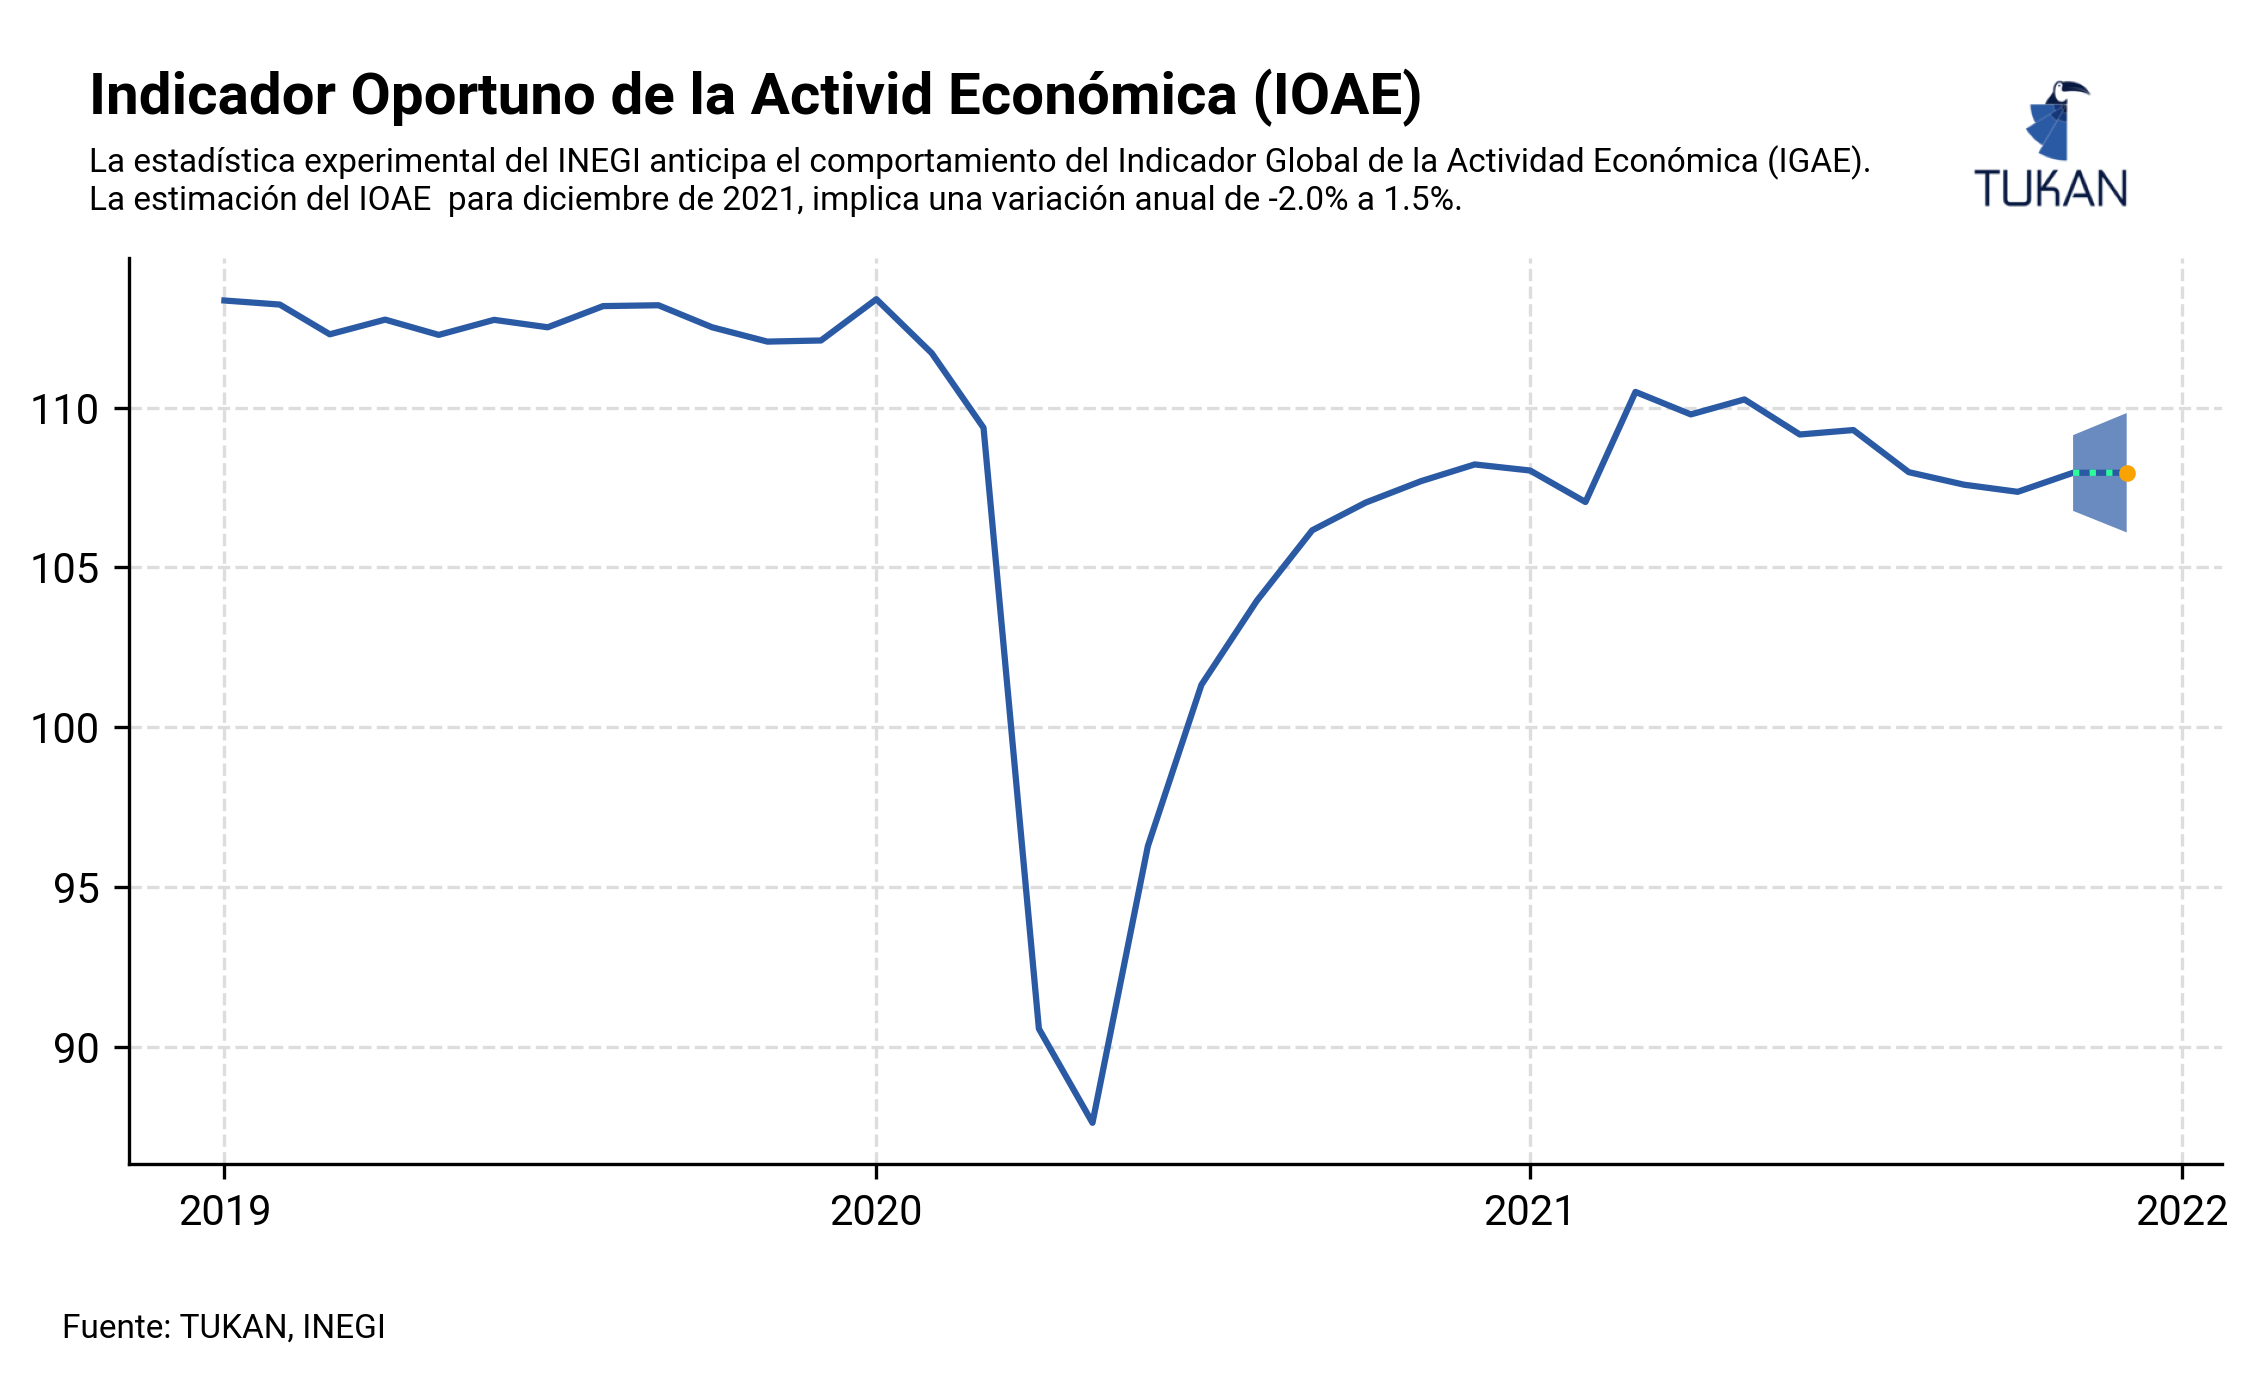

In [483]:
fig = plt.figure(dpi=300, figsize=(9,4))
ax = plt.subplot(111)

ax.plot(index_data["date"], index_data["ioae"], zorder=3)
ax.fill_between(index_data["date"], index_data["superior_ioae"], index_data["inferior_ioae"], alpha=0.7, zorder=2)
ax.plot(index_data["date"].tail(2), index_data["ioae"].tail(2), zorder=3, linestyle=':')
plt.plot(index_data["date"].tail(1), index_data["ioae"].tail(1), marker="o", markersize=3, zorder=3) 

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Add minor gridlines and format ticks
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_minor_locator(mdates.YearLocator(2))

ax.grid(visible=True, which='minor', linestyle='--')

igae_lag = index_data["igae"].iloc[-13]
est_puntual = index_data["ioae"].iloc[-1]
rango_superior = index_data["superior_ioae"].iloc[-1]
rango_inferior = index_data["inferior_ioae"].iloc[-1]

var_est= ((est_puntual/igae_lag)-1)*100
var_sup= ((rango_superior/igae_lag)-1)*100
var_inf= ((rango_inferior/igae_lag)-1)*100

fig.text(
    0.11,
    1,
    "Indicador Oportuno de la Activid Económica (IOAE)",
    size=14,
    weight = "bold"
)

fig.text(
    0.11,
    0.92,
    'La estadística experimental del INEGI anticipa el comportamiento del Indicador Global de la Actividad Económica (IGAE).\nLa estimación del IOAE  para diciembre de 2021, implica una variación anual de '+str(var_inf.round(1))+'% a '+str(var_sup.round(1))+'%.',
    size=8 #var_est.round(2)
)
# Add footer
fig.text(0.1, -0.02, "Fuente: TUKAN, INEGI", fontsize=8)


tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.72, .88, 0.16, 0.19], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")


plt.savefig(
    "plots/ioae_igae_ts_logo_white.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

In [484]:
index_data = ioae.merge(igae, on='date', how='left')
index_data = index_data[index_data['date']>=ioae['date'].min()]
# index_data = index_data[index_data['date']>='2019-01-01']
index_data['dif_igae_ioae'] = index_data['igae'] - index_data['ioae']
index_data.reset_index(inplace=True, drop=True)
index_data.tail(5)

,date,ioae,superior_ioae,inferior_ioae,igae,var_igae,dif_igae_ioae
211,2021-08-01,107.981545,NaN,NaN,108.045202,0.038848,0.063657
212,2021-09-01,107.588867,NaN,NaN,107.723464,0.013927,0.134597
213,2021-10-01,107.366278,NaN,NaN,107.541676,0.003757,0.175398
214,2021-11-01,107.962441,109.140275,106.769366,107.917536,0.002876,-0.044905
215,2021-12-01,107.963986,109.832034,106.095623,NaN,NaN,NaN


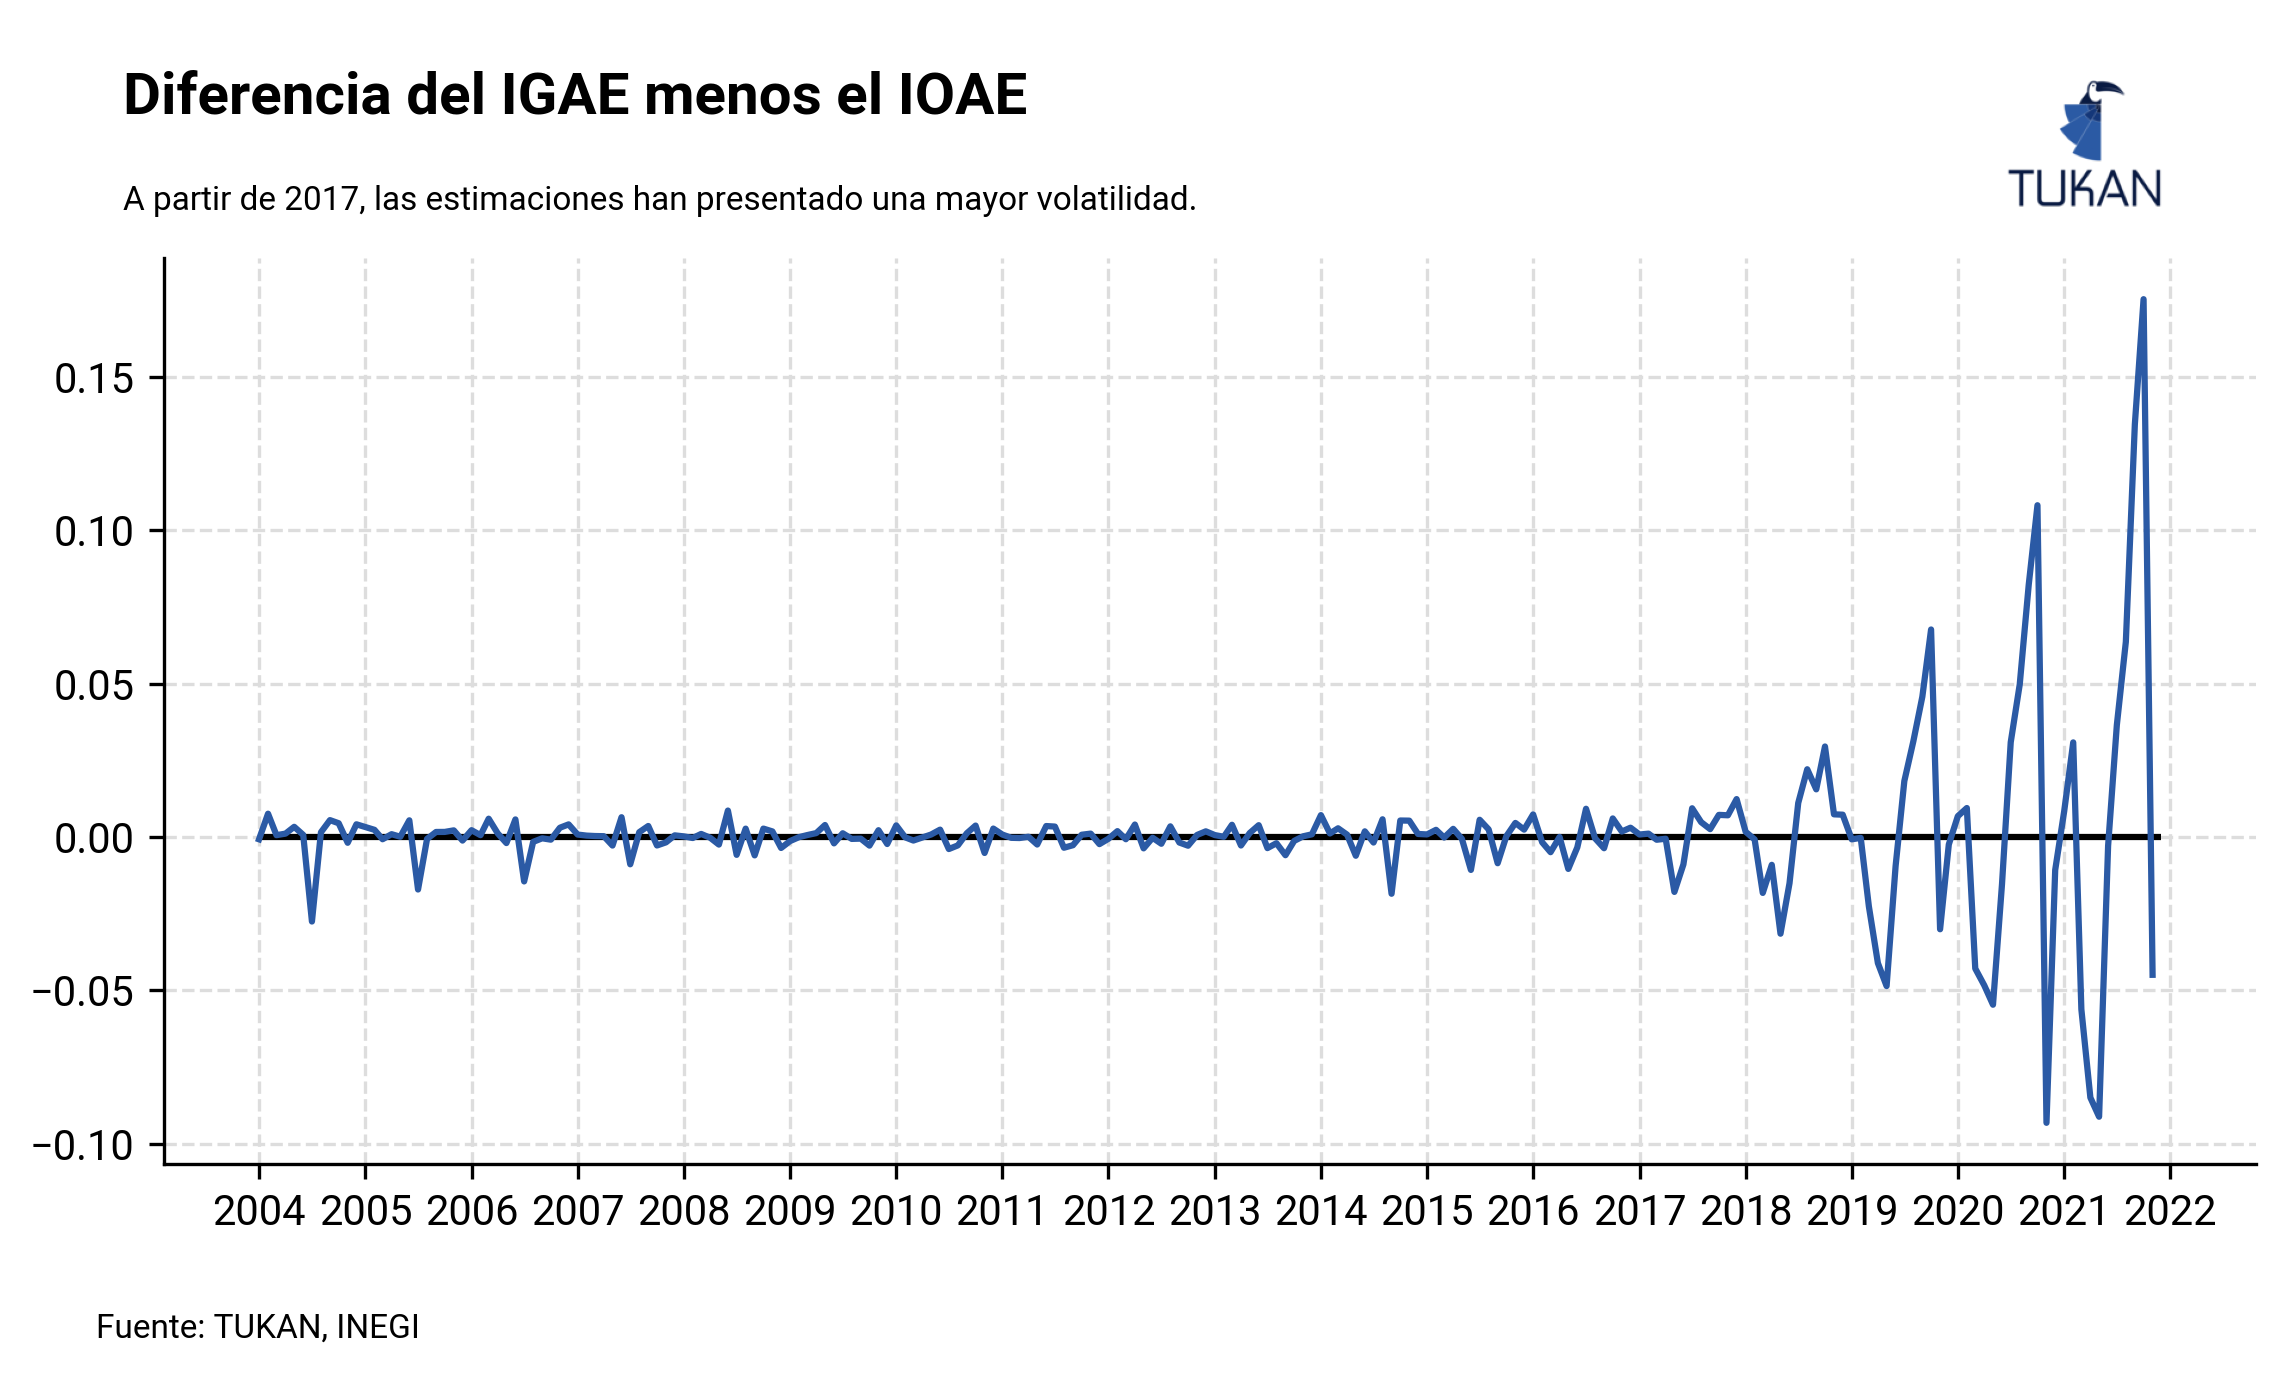

In [485]:
fig = plt.figure(dpi=300, figsize=(9,4))
ax = plt.subplot(111)

ax.plot(index_data["date"], index_data["dif_igae_ioae"], zorder=3)
ax.hlines(y=0, xmin=index_data["date"].min(), xmax= index_data["date"].max(),color='black', zorder=2)

# ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Add minor gridlines and format ticks
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_minor_locator(mdates.YearLocator(2))

ax.grid(visible=True, which='minor', linestyle='--')

# ax.set_ylim(0)

fig.text(
    0.11,
    1,
    "Diferencia del IGAE menos el IOAE",
    size=14,
    weight = "bold"
)

fig.text(
    0.11,
    0.92,
    'A partir de 2017, las estimaciones han presentado una mayor volatilidad.',
    size=8
)
# Add footer
fig.text(0.1, -0.02, "Fuente: TUKAN, INEGI", fontsize=8)


tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.72, .88, 0.16, 0.19], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")


plt.savefig(
    "plots/dif_ioae_igae_ts_logo_white.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

#### Yearly var

In [486]:
var_ioae = pd.read_excel(xls,xls.sheet_names[1])
var_ioae['Fecha'] = var_ioae['Fecha']+'/01'
var_ioae['Fecha'] = pd.to_datetime(var_ioae['Fecha'], format='%Y/%m/%d')
var_ioae['Variación anual IOAE'] = var_ioae['Variación anual IOAE'].fillna(var_ioae['Variación anual IGAE'])
var_ioae.drop(columns='Variación anual IGAE', inplace=True)
var_ioae.rename(columns={'Fecha':'date','Variación anual IOAE':'var_ioae','Límite superior IOAE':'superior_ioae','Límite inferior IOAE':'inferior_ioae'}, inplace=True)
var_ioae['var_ioae'] = var_ioae['var_ioae']/100
var_ioae

,date,var_ioae,superior_ioae,inferior_ioae
0,2004-01-01,0.026012,NaN,NaN
1,2004-02-01,0.020217,NaN,NaN
2,2004-03-01,0.041147,NaN,NaN
3,2004-04-01,0.037812,NaN,NaN
4,2004-05-01,0.047862,NaN,NaN
...,...,...,...,...
211,2021-08-01,0.038733,NaN,NaN
212,2021-09-01,0.013446,NaN,NaN
213,2021-10-01,0.003134,NaN,NaN
214,2021-11-01,0.002425,1.336158,-0.865218


In [487]:
var_data = var_ioae.merge(igae, on='date', how='left')
var_data = var_data[var_data['date']>=ioae['date'].min()]
# var_data = var_data[var_data['date']>='2019-01-01']
var_data.reset_index(inplace=True, drop=True)
var_data.tail(5)

,date,var_ioae,superior_ioae,inferior_ioae,igae,var_igae
211,2021-08-01,0.038733,NaN,NaN,108.045202,0.038848
212,2021-09-01,0.013446,NaN,NaN,107.723464,0.013927
213,2021-10-01,0.003134,NaN,NaN,107.541676,0.003757
214,2021-11-01,0.002425,1.336158,-0.865218,107.917536,0.002876
215,2021-12-01,-0.002397,1.486362,-1.966134,NaN,NaN


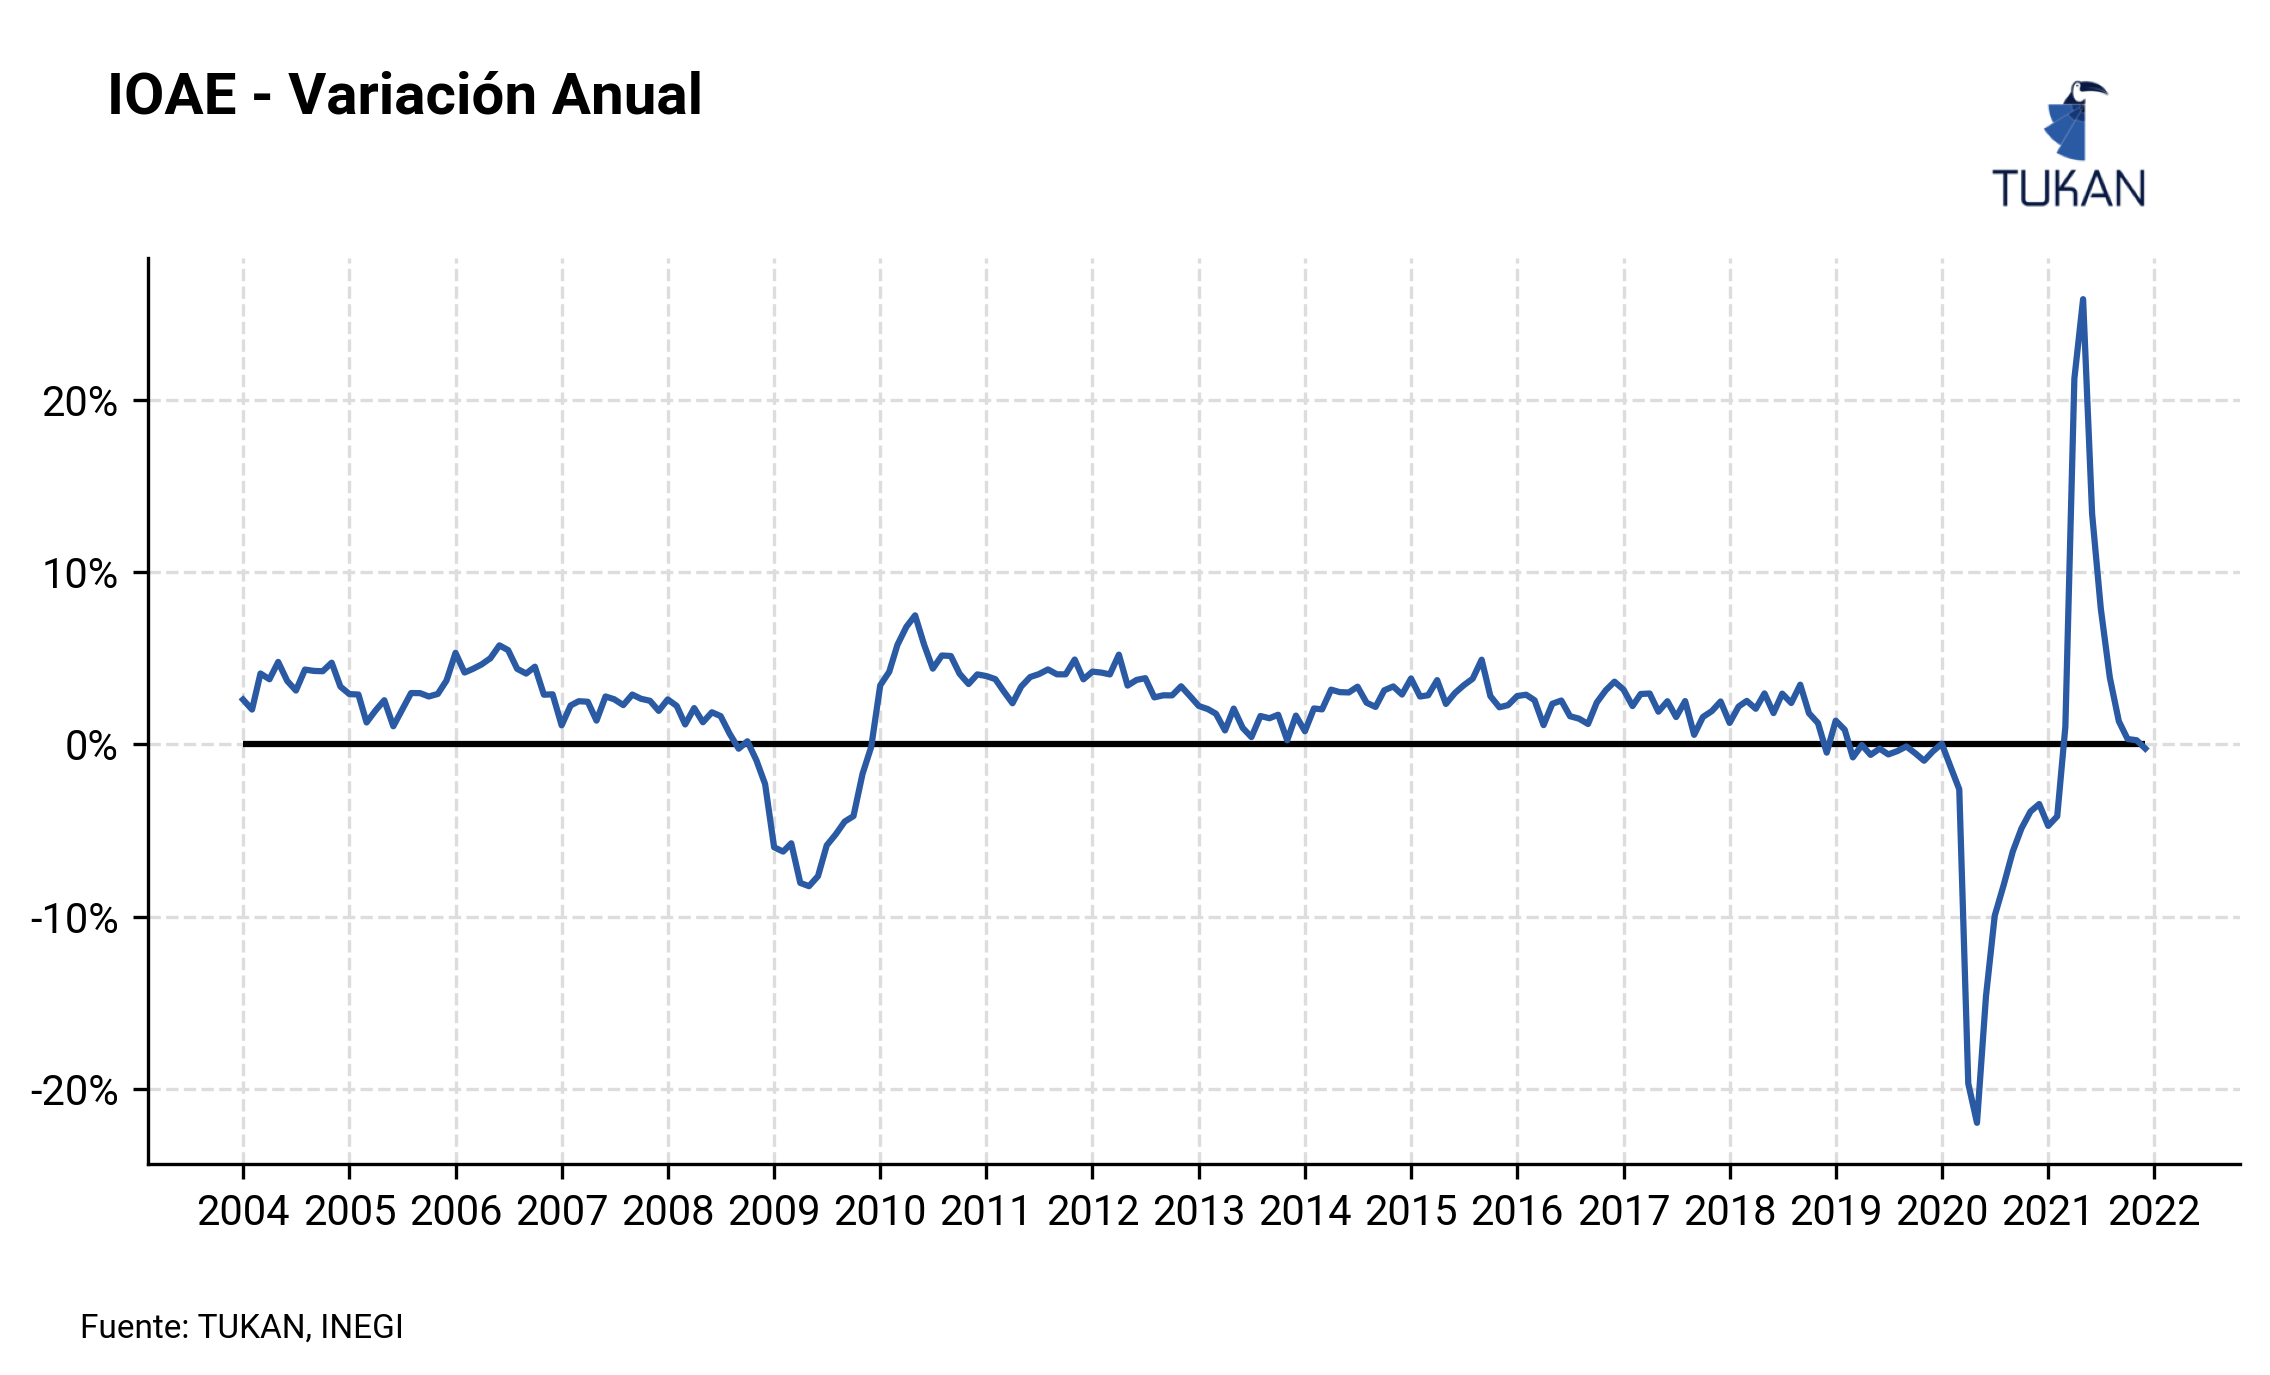

In [488]:
fig = plt.figure(dpi=300, figsize=(9,4))
ax = plt.subplot(111)

ax.plot(var_data["date"], var_data["var_ioae"], zorder=3)
# ax.plot(var_data["date"], var_data["var_igae"], zorder=3)
ax.hlines(y=0, xmin=var_data["date"].min(), xmax= var_data["date"].max(),color='black', zorder=2)

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0%}'))

# Add minor gridlines and format ticks
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_minor_locator(mdates.YearLocator(2))

ax.grid(visible=True, which='minor', linestyle='--')

# ax.set_ylim(0)

fig.text(
    0.11,
    1,
    "IOAE - Variación Anual",
    size=14,
    weight = "bold"
)

# fig.text(
#     0.11,
#     0.92,
#     'Sub',
#     size=8
# )
# Add footer
fig.text(0.1, -0.02, "Fuente: TUKAN, INEGI", fontsize=8)


tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.72, .88, 0.16, 0.19], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")


plt.savefig(
    "plots/var_ioae_ts_logo_white.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

### Secondary Index

In [489]:
sec_ioae = pd.read_excel(xls,xls.sheet_names[6])
sec_ioae['Fecha'] = sec_ioae['Fecha']+'/01'
sec_ioae['Fecha'] = pd.to_datetime(sec_ioae['Fecha'], format='%Y/%m/%d')
sec_ioae['Índice'] = sec_ioae['Índice'].fillna(sec_ioae['Nowcasts'])
sec_ioae['Límite superior'] = sec_ioae['Límite superior'].fillna(sec_ioae['Límite superior'].iloc[-1])
sec_ioae['Límite inferior'] = sec_ioae['Límite inferior'].fillna(sec_ioae['Límite inferior'].iloc[-1])
sec_ioae.drop(columns='Nowcasts', inplace=True)
sec_ioae.rename(columns={'Fecha':'date','Índice':'ioae','Límite superior':'superior_ioae','Límite inferior':'inferior_ioae'}, inplace=True)
sec_ioae

,date,ioae,superior_ioae,inferior_ioae
0,2004-01-01,90.997062,99.741448,96.453882
1,2004-02-01,90.858899,99.741448,96.453882
2,2004-03-01,92.339651,99.741448,96.453882
3,2004-04-01,92.232909,99.741448,96.453882
4,2004-05-01,92.139784,99.741448,96.453882
...,...,...,...,...
211,2021-08-01,98.878582,99.741448,96.453882
212,2021-09-01,97.777097,99.741448,96.453882
213,2021-10-01,98.384950,99.741448,96.453882
214,2021-11-01,98.281090,99.741448,96.453882


In [490]:
secondary_index_data = sec_ioae.merge(sec_igae, on='date', how='left')
secondary_index_data = secondary_index_data[secondary_index_data['date']>=sec_ioae['date'].min()]
secondary_index_data = secondary_index_data[secondary_index_data['date']>='2019-01-01']
secondary_index_data['dif_igae_ioae'] = secondary_index_data['igae'] - secondary_index_data['ioae']
secondary_index_data.reset_index(inplace=True, drop=True)
secondary_index_data.tail(15)

,date,ioae,superior_ioae,inferior_ioae,igae,dif_igae_ioae
21,2020-10-01,96.815579,99.741448,96.453882,107.139104,10.323525
22,2020-11-01,97.573209,99.741448,96.453882,107.608046,10.034837
23,2020-12-01,97.746177,99.741448,96.453882,108.212711,10.466534
24,2021-01-01,97.647848,99.741448,96.453882,108.041838,10.393990
25,2021-02-01,97.851249,99.741448,96.453882,107.077594,9.226345
26,2021-03-01,98.239115,99.741448,96.453882,110.437835,12.198720
27,2021-04-01,98.624376,99.741448,96.453882,109.704366,11.079990
28,2021-05-01,98.431511,99.741448,96.453882,110.166825,11.735314
29,2021-06-01,97.559133,99.741448,96.453882,109.157906,11.598773
30,2021-07-01,98.462718,99.741448,96.453882,109.336247,10.873529


#### Plot

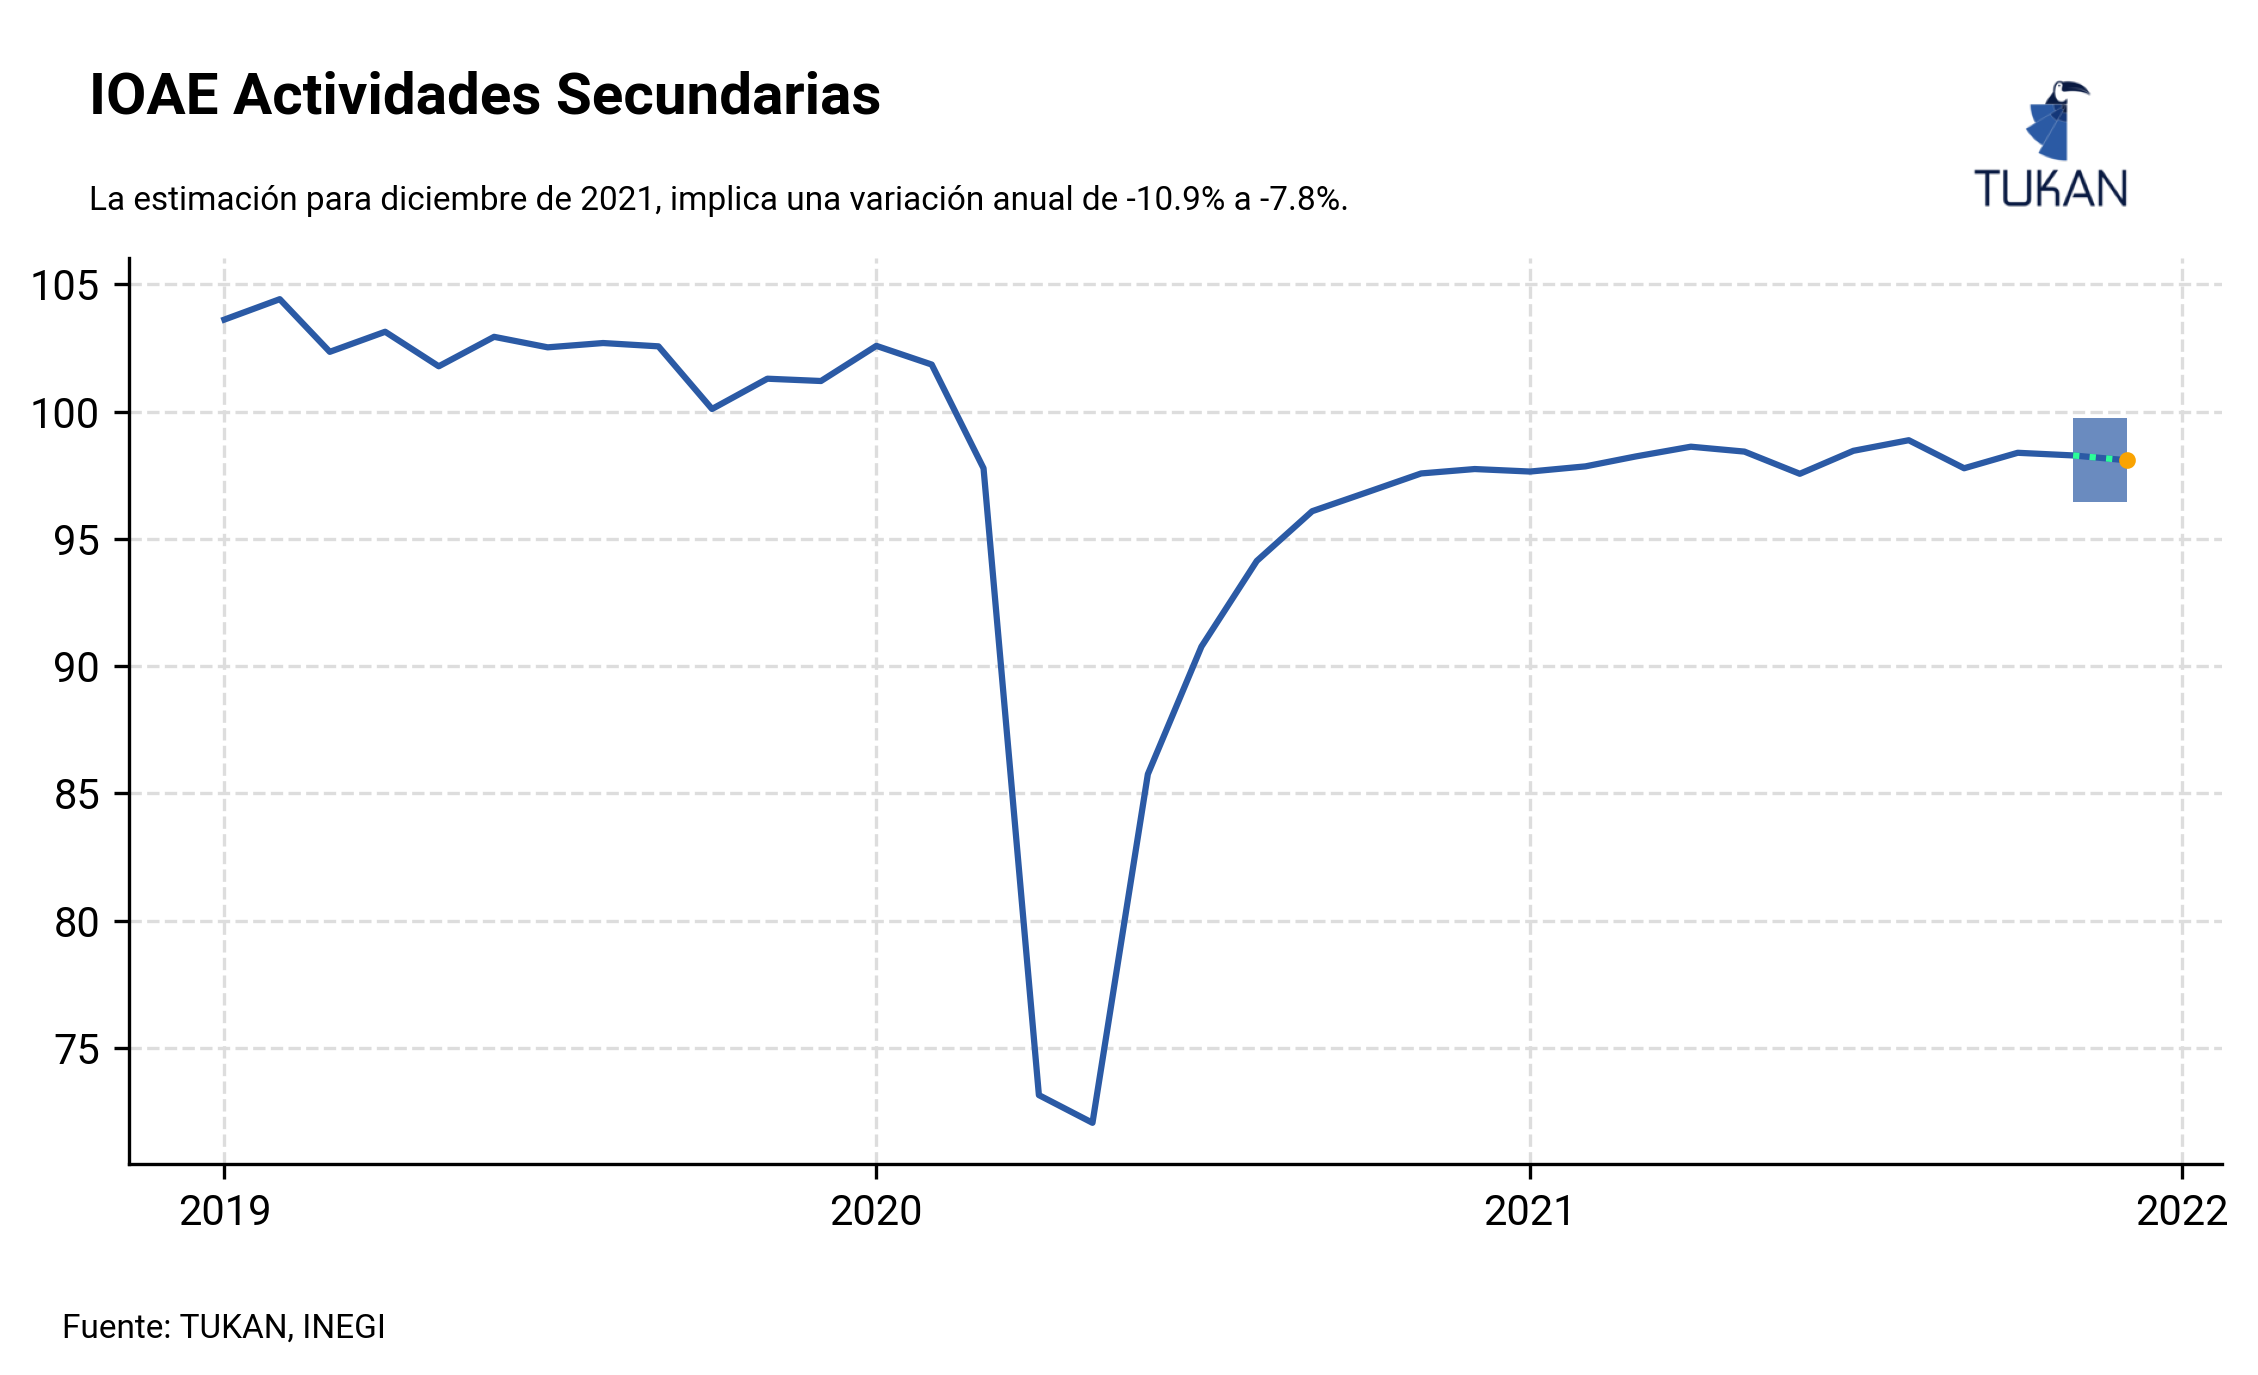

In [491]:
fig = plt.figure(dpi=300, figsize=(9,4))
ax = plt.subplot(111)

ax.plot(secondary_index_data["date"], secondary_index_data["ioae"], zorder=3)
ax.fill_between(secondary_index_data["date"].tail(2), secondary_index_data["superior_ioae"].tail(2), secondary_index_data["inferior_ioae"].tail(2), alpha=0.7, zorder=2)
ax.plot(secondary_index_data["date"].tail(2), secondary_index_data["ioae"].tail(2), zorder=3, linestyle=':')
plt.plot(secondary_index_data["date"].tail(1), secondary_index_data["ioae"].tail(1), marker="o", markersize=3, zorder=3) 

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Add minor gridlines and format ticks
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_minor_locator(mdates.YearLocator(2))

ax.grid(visible=True, which='minor', linestyle='--')

igae_lag = secondary_index_data["igae"].iloc[-13]
est_puntual = secondary_index_data["ioae"].iloc[-1]
rango_superior = secondary_index_data["superior_ioae"].iloc[-1]
rango_inferior = secondary_index_data["inferior_ioae"].iloc[-1]


var_est= ((est_puntual/igae_lag)-1)*100
var_sup= ((rango_superior/igae_lag)-1)*100
var_inf= ((rango_inferior/igae_lag)-1)*100

fig.text(
    0.11,
    1,
    "IOAE Actividades Secundarias",
    size=14,
    weight = "bold"
)

fig.text(
    0.11,
    0.92,
    'La estimación para diciembre de 2021, implica una variación anual de '+str(var_inf.round(1))+'% a '+str(var_sup.round(1))+'%.',
    size=8
)
# Add footer
fig.text(0.1, -0.02, "Fuente: TUKAN, INEGI", fontsize=8)


tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.72, .88, 0.16, 0.19], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")


plt.savefig(
    "plots/sec_ioae_igae_ts_logo_white.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

### Terciary Index

In [492]:
ter_ioae = pd.read_excel(xls,xls.sheet_names[9])
ter_ioae['Fecha'] = ter_ioae['Fecha']+'/01'
ter_ioae['Fecha'] = pd.to_datetime(ter_ioae['Fecha'], format='%Y/%m/%d')
ter_ioae['Índice'] = ter_ioae['Índice'].fillna(ter_ioae['Nowcasts'])
ter_ioae.drop(columns='Nowcasts', inplace=True)
ter_ioae.rename(columns={'Fecha':'date','Índice':'ioae','Límite superior':'superior_ioae','Límite inferior':'inferior_ioae'}, inplace=True)
# ter_ioae

In [493]:
terciary_index_data = ter_ioae.merge(ter_igae, on='date', how='left')
# terciary_index_data = terciary_index_data[terciary_index_data['date']>=ter_ioae['date'].min()]
terciary_index_data = terciary_index_data[terciary_index_data['date']>='2019-01-01']
terciary_index_data['dif_igae_ioae'] = terciary_index_data['igae'] - terciary_index_data['ioae']
terciary_index_data.reset_index(inplace=True, drop=True)
terciary_index_data.tail(15)

,date,ioae,superior_ioae,inferior_ioae,igae,dif_igae_ioae
21,2020-10-01,111.920159,NaN,NaN,107.139104,-4.781055
22,2020-11-01,112.733761,NaN,NaN,107.608046,-5.125715
23,2020-12-01,114.183600,NaN,NaN,108.212711,-5.970889
24,2021-01-01,112.987346,NaN,NaN,108.041838,-4.945508
25,2021-02-01,112.178683,NaN,NaN,107.077594,-5.101089
26,2021-03-01,116.013895,NaN,NaN,110.437835,-5.576060
27,2021-04-01,115.494247,NaN,NaN,109.704366,-5.789881
28,2021-05-01,115.923121,NaN,NaN,110.166825,-5.756296
29,2021-06-01,115.051701,NaN,NaN,109.157906,-5.893795
30,2021-07-01,114.609192,NaN,NaN,109.336247,-5.272945


#### Plot

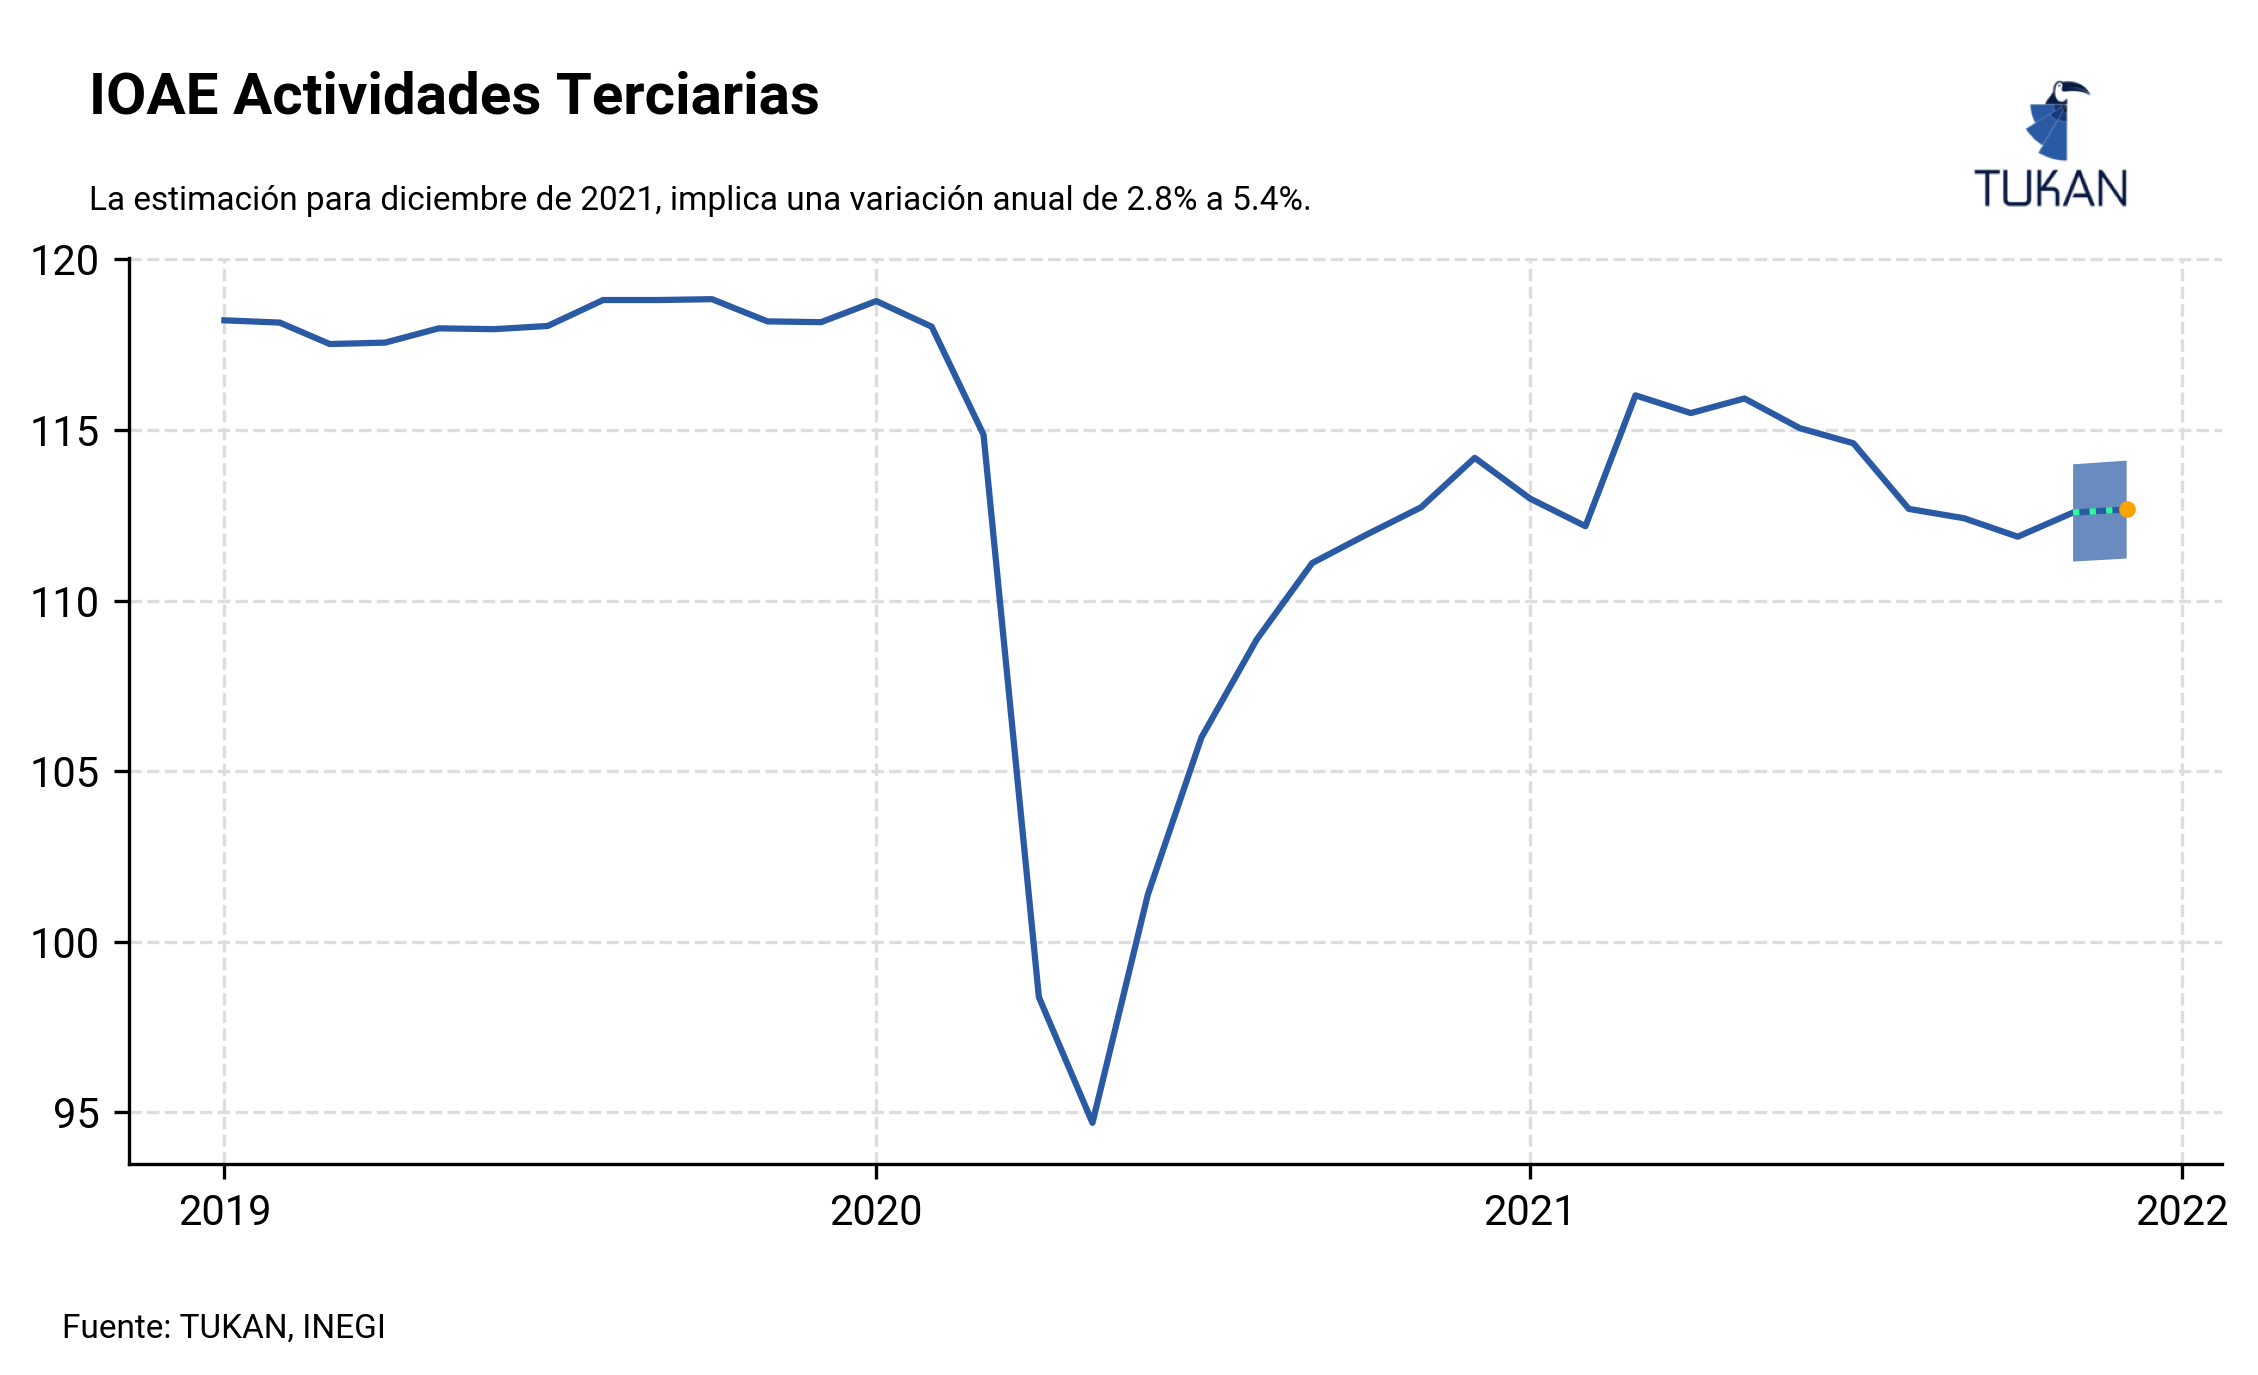

In [494]:
fig = plt.figure(dpi=300, figsize=(9,4))
ax = plt.subplot(111)

ax.plot(terciary_index_data["date"], terciary_index_data["ioae"], zorder=3)
ax.fill_between(terciary_index_data["date"], terciary_index_data["superior_ioae"], terciary_index_data["inferior_ioae"], alpha=0.7, zorder=2)
ax.plot(terciary_index_data["date"].tail(2), terciary_index_data["ioae"].tail(2), zorder=3, linestyle=':')
plt.plot(terciary_index_data["date"].tail(1), terciary_index_data["ioae"].tail(1), marker="o", markersize=3, zorder=3) 

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Add minor gridlines and format ticks
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_minor_locator(mdates.YearLocator(2))

ax.grid(visible=True, which='minor', linestyle='--')

igae_lag = terciary_index_data["igae"].iloc[-13]
est_puntual = terciary_index_data["ioae"].iloc[-1]
rango_superior = terciary_index_data["superior_ioae"].iloc[-1]
rango_inferior = terciary_index_data["inferior_ioae"].iloc[-1]

var_est= ((est_puntual/igae_lag)-1)*100
var_sup= ((rango_superior/igae_lag)-1)*100
var_inf= ((rango_inferior/igae_lag)-1)*100

fig.text(
    0.11,
    1,
    "IOAE Actividades Terciarias",
    size=14,
    weight = "bold"
)

fig.text(
    0.11,
    0.92,
    'La estimación para diciembre de 2021, implica una variación anual de '+str(var_inf.round(1))+'% a '+str(var_sup.round(1))+'%.',
    size=8
)
# Add footer
fig.text(0.1, -0.02, "Fuente: TUKAN, INEGI", fontsize=8)


tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.72, .88, 0.16, 0.19], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")


plt.savefig(
    "plots/ter_ioae_igae_ts_logo_white.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)